In [1]:
# Basics
import numpy as np
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# Custom
import sys
sys.path.insert(0, '../../src/utils')
from data_loader import DataLoader
import constants
sys.path.insert(0, '../../src/modeling')
from network import Network
import evaluation as ev

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

KeyboardInterrupt: 

In [ ]:
def create_model(hp):
    
    model = Sequential()
    
    # Input
    model.add(Dense(
        constants.TRACE_LEN,
        activation='relu')
    )

    # First BatchNorm
    model.add(BatchNormalization())

    # Hidden
    for _ in range(hp['hidden_layers']):
        model.add(Dense(
            hp['hidden_neurons'],
            # kernel_regularizer=L2(1e-4),
            activation='relu')
        )

        # Dropout
        # model.add(Dropout(hp['dropout_rate']))

    # Second BatchNorm
    # model.add(BatchNormalization())

    # Output
    model.add(Dense(256, activation='softmax'))
    
    # Compilation
    lr = hp['learning_rate']
    if hp['optimizer'] == 'sgd':
        opt = SGD(learning_rate=lr)
    elif hp['optimizer'] == 'adam':
        opt = Adam(learning_rate=lr)
    else:
        opt = RMSprop(learning_rate=lr)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [3]:
HP = {
    'hidden_layers':      [3, 4, 5, 6],
    'hidden_neurons':     [300, 500, 700],
    # 'dropout_rate':       0.5,
    'optimizer':          ['adam', 'rmsprop'],
    'learning_rate':      [1e-5, 1e-4, 1e-5, 1e-6],
    'batch_size':         [256, 512, 1024]
}

callbacks = []

callbacks.append(EarlyStopping(
    monitor='val_loss', 
    patience=35))

callbacks.append(ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-8))

In [4]:
# # PLOT_HISTORY FUNCTION
# def plot_history(history, i):
#     f, ax = plt.subplots(2, 1, figsize=(10,12))
    
#     ax[0].plot(history['loss'], label='train_loss')
#     ax[0].plot(history['val_loss'], label='val_loss')
#     ax[0].axhline(y=history['loss'][-1], ls='--', linewidth=0.5)
#     ax[0].axhline(y=history['val_loss'][-1], ls='--', linewidth=0.5)
#     ax[0].set_title('Train-Loss vs Val-Loss')
#     ax[0].set_ylabel('Loss')
#     ax[0].set_xlabel('Epochs')
    
#     ax[1].plot(history['accuracy'], label='train_acc')
#     ax[1].plot(history['val_accuracy'], label='val_acc')
#     ax[1].axhline(y=history['accuracy'][-1], ls='--', linewidth=0.5)
#     ax[1].axhline(y=history['val_accuracy'][-1], ls='--', linewidth=0.5)
#     ax[1].set_title('Train-Acc vs Val-Acc')
#     ax[1].set_ylabel('Acc')
#     ax[1].set_xlabel('Epochs')
      
#     plt.show()
#     # f.savefig(
#     #     f'./train_history_{i}keys.png', 
#     #     bbox_inches='tight', 
#     #     dpi=100
#     # )

In [5]:
# def save_results(ge, test_config, score, i):

#     ge_dict = {f'{j+1}traces': el for j, el in enumerate(ge)}
#     ge_dict['test_config'] = test_config
#     ge_dict['score'] = score
#     ge_df = pd.DataFrame(ge_dict, index=[0])
        
#     if f'res_{i}keys.csv' not in os.listdir('./'):
#         ge_df.to_csv(f'./res_{i}keys.csv', index=False)
#     else:
#         df = pd.read_csv(f'./res_{i}keys.csv')
#         df = pd.concat([df, ge_df]).reset_index(drop=True)
#         df.to_csv(f'./res_{i}keys.csv', index=False)
        

# def plot_ge_per_trainConfig(ges, scores, test_configs, n, i):
        
#     # Get the colorset
#     cmap = plt.cm.jet # Google Turbo
#     colors = cmap(range(0, cmap.N, int(cmap.N/len(ges))))
    
#     # Plot
#     f, ax = plt.subplots(figsize=(10,5))
#     ax.plot(np.zeros(n), color='r', ls='--', linewidth=0.5)

#     for i, ge in enumerate(ges):
#         if n <= 100:
#             ax.plot(ge[:n], label=f'vs{test_configs[i]}', color=colors[i], marker='o')
#             ax.set_xticks(range(n), labels=range(1, n+1))
#             ax.grid()
#         else:
#             ax.plot(ge[:n], label=test_configs[i], color=colors[i])
#         ax.legend()
#         ax.set_title(f'Train config: #dev={len(train_devs)}, #keys={i}')
#         ax.set_xlabel('Number of traces')
#         ax.set_ylabel('GE')

#     # plt.show()
#     f.savefig(
#         f'./GE_{n}_{i}keys.png', 
#         bbox_inches='tight', 
#         dpi=100)
    
        
        
# def plot_results(ge_test_traces, i):

#     df = pd.read_csv(f'./res_{i}keys.csv')
#     ges = df.loc[:, :f'{ge_test_traces}traces'].values
#     test_configs = list(df['test_config'])
#     scores = list(df['score'])

#     # plot_ge_per_trainConfig(ges, scores, test_configs, int(ge_test_traces/2), i)
#     plot_ge_per_trainConfig(ges, scores, test_configs, ge_test_traces, i)

In [21]:
N_MODELS = 5
BYTE_IDX = 0
GE_TEST_TRACES = 10
EPOCHS = 100

CONFIGS = [['D1-K1'], ['D2-K2'], ['D3-K3']]
TARGETS = ['D2', 'D3', 'D1'] 

ges = []
for i, config in enumerate(CONFIGS):
    
    print(f'==============  Config: {config}  ==============')
    
    train_paths = [constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{c}_train.json' for c in config]
    val_paths = [constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{c}_test.json' for c in config]

    train_dl = DataLoader(train_paths, BYTE_IDX)
    x_train, y_train, _, _ = train_dl.load_data()
    # scaler = StandardScaler()
    # x_train = scaler.fit_transform(x_train)

    val_dl = DataLoader(val_paths, BYTE_IDX)
    x_val, y_val, _, _ = val_dl.load_data()
    
    res = []
    for m in range(N_MODELS):
        random_hp = {k: random.choice(HP[k]) for k in HP.keys()}
        model = create_model(random_hp)
        history = model.fit(
            x_train, 
            y_train, 
            validation_data=(x_val, y_val),
            epochs=EPOCHS,
            batch_size=random_hp['batch_size'],
            callbacks=callbacks,
            verbose=0
        )
        
        _, val_acc = model.evaluate(x_val, y_val, verbose=0)
        print(f'Model_{m}: {val_acc:.4f}')
        
        res.append((random_hp, val_acc))
        
    res.sort(key=lambda x: x[1], reverse=True)
    
    best_hp, best_val_acc = res[0]
    print(f'Best Val Acc for {config}: {best_val_acc:.4f}')
    print('Best hp:')
    print(best_hp)
    
    attack_model = create_model(best_hp)
    attack_model.fit(
        np.concatenate((x_train, x_val), axis=0),
        np.concatenate((y_train, y_val), axis=0),
        epochs=EPOCHS,
        batch_size=best_hp['batch_size'],
        verbose=0
    )
        
    test_dev = TARGETS[i]
    print(f'Test dev: {test_dev}')
    test_path = constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{test_dev}-K0_test.json'
    test_dl = DataLoader([test_path], BYTE_IDX)
    
    # ge = ev.guessing_entropy(
    #     attack_model,
    #     test_dl=test_dl,
    #     n_exp=100,
    #     n_traces=GE_TEST_TRACES)
    
    ge = ev.NEW_guessing_entropy(
        attack_model,
        test_dl=test_dl,
        n_exp=100,
        n_traces=GE_TEST_TRACES)

    # score = ev.ge_score(ge, 5)
    # print(f'Attack Score for {config}: {score}')

#     save_results(ge, test_config, score, i)
    
#     plot_results(GE_TEST_TRACES, i)

    ges.append(ge)
    
    clear_session()
    print()

==============  Config: ['D1-K1']  ==============
Model_0: 0.0046
Model_1: 0.1595
Model_2: 0.0185
Model_3: 0.1573
Model_4: 0.1687
Best Val Acc for ['D1-K1']: 0.1687
Best hp:
{'hidden_layers': 4, 'hidden_neurons': 300, 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 256}
Test dev: D2

==============  Config: ['D2-K2']  ==============
Model_0: 0.0970
Model_1: 0.0086
Model_2: 0.0912
Model_3: 0.0988
Model_4: 0.1236
Best Val Acc for ['D2-K2']: 0.1236
Best hp:
{'hidden_layers': 4, 'hidden_neurons': 300, 'optimizer': 'adam', 'learning_rate': 1e-05, 'batch_size': 256}
Test dev: D3

==============  Config: ['D3-K3']  ==============
Model_0: 0.1296
Model_1: 0.0294
Model_2: 0.0895
Model_3: 0.0141
Model_4: 0.0964
Best Val Acc for ['D3-K3']: 0.1296
Best hp:
{'hidden_layers': 3, 'hidden_neurons': 300, 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 512}
Test dev: D1



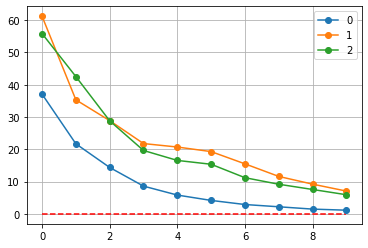

In [22]:
plt.plot(np.zeros(10), color='r', ls='--')

for i, ge in enumerate(ges):
    plt.plot(ge, label=f'{i}', marker='o')

plt.grid()
plt.legend()
plt.show()

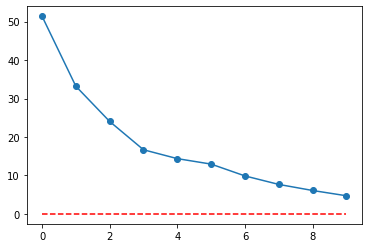

In [23]:
ges = np.array(ges)
avg_ge = np.mean(ges, axis=0)

plt.plot(np.zeros(10), color='r', ls='--')
plt.plot(avg_ge, marker='o')
plt.show()

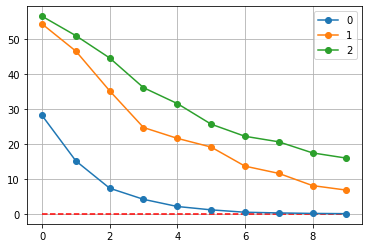

In [18]:
##### GEs for D1-K1, D2-K2, D3-K3, old GE function #####

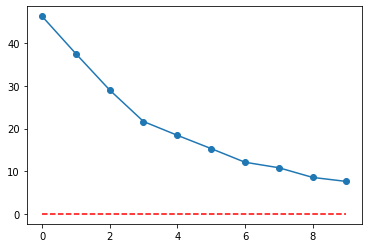

In [19]:
##### Avg GE for D1-K1, D2-K2, D3-K3, old GE funcion #####